In this notebook we are going to train a random forest based on the last layer of the cnn classifier and some extra information. We will use the train and validation dataset

In [12]:
import sys, os
import numpy as np
from  sklearn.ensemble import RandomForestClassifier
import pickle
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy import misc
import random

%matplotlib inline
# this file should be run from {caffe_root}/examples (otherwise change this line)
caffe_root = '/media/hermetico/2TB/frameworks/caffe/'  

this_root = os.path.abspath('.')
activities_net = {
    'deploy': os.path.join(this_root, 'models/finetuning-alexnet/deploy.prototxt'),
    'model': os.path.join(this_root, 'models/finetuning-alexnet/reference_activitiesnet.caffemodel'),
    'forest': os.path.join(this_root, 'models/finetuning-alexnet/forest')
}

# the paths for the labels and for the dataset
labels_path = os.path.join(caffe_root, 'data/daily_activities/labels.txt')
# train and validation dataset
train_dataset_path = os.path.join(caffe_root, 'data/daily_activities/train.txt')
val_dataset_path = os.path.join(caffe_root, 'data/daily_activities/val.txt')
test_dataset_path = os.path.join(caffe_root, 'data/daily_activities/test.txt')
sys.path.insert(0, caffe_root + 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [13]:
# here we merge train and validation datasets into the train dataset
train_dataset = [ 
    line.split(' ') for line in list(np.loadtxt(train_dataset_path, str, delimiter='\n')) + \
    list(np.loadtxt(val_dataset_path, str, delimiter='\n')) if len(line.split(' ')) == 2 # there are some images with wierd paths
]

train_paths, train_labels = zip(*[(path, int(label)) for path, label in train_dataset])
# the test dataset
test_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(test_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
test_paths, test_labels = zip(*[(path, int(label)) for path, label in test_dataset])

labels = list(np.loadtxt(labels_path, str, delimiter='\n'))
NUM_LABELS = len(labels)
# results are not the same when loading a bunch of pictures
FORCE_TRAIN = False
USE_BATCHES = False
BATCH_SIZE = 1
print "%i labels loaded" % NUM_LABELS
print "%i train images" % (len(train_paths))
print "%i test images" % (len(test_paths))
print "%i batch size for the training process" % BATCH_SIZE

21 labels loaded
15848 train images
2796 test images
1 batch size for the training process


In [14]:
# loads activities net 
activitiesnet = caffe.Net(activities_net['deploy'], activities_net['model'], caffe.TEST)
def reshape_caffe_transformer(input_size, net):
    net.blobs['data'].reshape(input_size,3,227,227)

    # Preprocessing for caffe inputs
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    
    return net, transformer


# modifies the input size of the net and generates a transformer
activitiesnet, transformer = reshape_caffe_transformer(BATCH_SIZE, activitiesnet)

In [15]:
def extract_features_shape(net, layers, batch_size=1):
    """Returns the shape of the features batch, is 2D"""
    shapes = [batch_size,0]
    for layer in layers:
        shapes[1] += net.blobs[layer].data.shape[1]
    return tuple(shapes)


def extract_features(net, path, layers):
    """A function which extracts the features of the an input image"""
    # loads the images
    image = caffe.io.load_image(path)
    # preprocess for the images
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()

    features = np.array([])
    for layer in layers:
        features = np.append(features, net.blobs[layer].data.copy()[0])
    return features


def extract_batch_features(net, paths, shape, layers):
    """A function which extracts the features of the an input array images"""
    # loads the images
    images = [ caffe.io.load_image(image) for image in paths]
    # preprocess for the images
    net.blobs['data'].data[...] = [transformer.preprocess('data', image) for image in images]
    net.forward()
    # output array with the new shape

    # the output features have the input shape X * Y
    # but given features are X * Z
    # here we concat x * Z1 + Z2
    # instead of append and merge, just optimizing stuff
    features = np.zeros(shape)
    offset = 0
    for layer in layers:
        given_features = net.blobs[layer].data.copy()
        features[:, offset : offset + given_features.shape[1]] = given_features
        offset += given_features.shape[1]
    return features

def show_image_from_path(path, label=None):
    if label is not None:
        print "Label:", label
    display(Image(filename=path))

    
# misc
def disp_pred(net, forest, labels, image_path, layer='probs'):
    """This function recieves a net and an image_path, and returns the prediction"""
    plt.imshow(misc.imread(image_path))
    features = extract_features(net, image_path, layer)
    return labels[rf.predict([features])[0]]

In [16]:
## Functions to train the forest
def train_forest_with_batches( layers ):
    batch_size = BATCH_SIZE
    shape_features = extract_features_shape(activitiesnet, layers, BATCH_SIZE)
    total_samples = len(train_paths)
    cores = 6 # number of cores for the random forest, is CPU wise
    # creates and trains 500 forests over 8 cores
    rf = RandomForestClassifier(n_estimators=500, n_jobs=cores)
    iteration = 0
    offset = 0
    # if the total samples is not divisible by the batch_size wi will loose
    # the last ones, but we can avoid it by extending the dataset with random images
    # of the dataset to fit the batch size
    while offset + batch_size <= total_samples:
        # selects the samples    
        paths_samples = train_paths[offset:offset + batch_size]
        labels_samples = train_labels[offset:offset + batch_size]
        
        # extract the features
        features_samples = extract_features(activitiesnet, paths_samples, shape_features, layers)
        
        # trains the forest
        rf.fit(features_samples, labels_samples)
        print "Iteration %i (%i,%i)" % (iteration, offset + BATCH_SIZE, total_samples)

        offset += batch_size
        iteration += 1
    return rf



## Functions to train the forest
def train_forest(layers):
    shape_features = extract_features_shape(activitiesnet, layers, BATCH_SIZE)
    num_samples = len(train_paths)
    # Extract features of the images images
    train_features = np.zeros((num_samples, shape_features[1]))
    for i, img in enumerate(train_paths):
        train_features[i] = extract_features(activitiesnet, img, layers)
        
        if i % 500 == 0:
            print "Current index %i"%(i)
    
    
    cores = 8
    # creates and trains 500 forests over 8 cores
    rf = RandomForestClassifier(n_estimators=500, n_jobs=cores)
    rf.fit(train_features, train_labels)

    return rf


def maybe_train(forest_path, layers, force_train=False, batches=True, ext='.pck'):
    """Loads the random forest from the file or geneates it if it does not exist"""
    filename = forest_path + "_" + "_".join(layers) + ext
    if not os.path.isfile(filename) or force_train:
        print "Generating the forest"
        if batches:
            forest = train_forest_with_batches(layers)
        else:
            forest = train_forest(layers)
        print "Saving forest in", filename
        with open(filename, 'w') as f:
            pickle.dump(forest, f, pickle.HIGHEST_PROTOCOL)
    else:
        print "Loading forest from", filename
        with open(filename, 'r') as f:
            forest = pickle.load(f)
    return forest

In [17]:
### Functions to evaluate the accuracy of each category

def eval_category(net, rf, category, label, layers):
    num_samples = len(category)
    num_features = extract_features_shape(net, layers)[1]
    features = np.zeros((num_samples, num_features))
    for i, path in enumerate(category):
        features[i] = extract_features(net, path, layers)
    top_labels = np.array(rf.predict(features))
    return np.count_nonzero(top_labels == label) / float(num_samples)

def eval_categories(net, rf,  categories, layers):
    accuracies = np.zeros(len(categories))
    for i, category in enumerate(categories):
        accuracies[i] = eval_category(net, rf, category, i, layers)
    return accuracies * 100



#### Function to evaluate the accuracy of the whole test dataset
def eval_global(net, rf, paths, labels, layers):
    num_samples = len(paths)
    num_features = extract_features_shape(net, layers)[1]
    top_labels = np.zeros((num_samples))
    for i, path in enumerate(paths):
        features = extract_features(net, path, layers)
        top_labels[i] = rf.predict([features])[0]
    return np.count_nonzero(top_labels == labels) / float(num_samples) * 100., top_labels

In [18]:
# functions to show accuracys and plots
def show_accuracies(accuracies, layers):
    print "Class accuracy for a tree trained with a cnn layers", layers
    for i, acc in enumerate(accuracies):
        print "%s: %i" %(labels[i], acc)
    
    # let's show a plot
    y_pos = np.arange(NUM_LABELS)
    plt.barh(y_pos, accuracies,  alpha=1)
    plt.yticks(y_pos, labels)
    plt.xlabel('Accuracy')
    plt.title('List of categories and accuracy')
    plt.show()  
    
    
    
def show_confusion_matrix(true_labels, top_labels, labels):
    # confusion matrix
    matrix = confusion_matrix(true_labels, top_labels)
    # normalize confutsion matrix
    num_per_class , _ = np.histogram(test_labels, len(labels))
    for i, row in enumerate(matrix):
        matrix[i] = matrix[i] * 100.  / num_per_class[i]
    
    

    norm_conf = []
    for i in matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(10,7))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.GnBu, 
                    interpolation='nearest')

    width, height = matrix.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    cb = fig.colorbar(res)
    alphabet = labels
    ax.xaxis.tick_top()
    plt.xticks(range(width), alphabet[:width], rotation='vertical')
    plt.yticks(range(height), alphabet[:height])

In [19]:
# we are going to define a batch, to proccess more images during training
shape_features = extract_features_shape(activitiesnet, ('fc6', 'probs'), BATCH_SIZE)
print "Shape of features of one batch", shape_features 

# extract features
dummy_feature = extract_features(activitiesnet, train_paths[0],  ('fc6', 'probs'))
print "Example of one feature with shape ", dummy_feature.shape
print dummy_feature

# extract features
dummy_feature = extract_batch_features(activitiesnet, train_paths[:BATCH_SIZE], shape_features, ('fc6', 'probs'))
print "Example of features "
print dummy_feature[:5]

Shape of features of one batch (1, 4117)
Example of one feature with shape  (4117,)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   8.09754491e-01
   3.22430469e-02   7.21639488e-04]
Example of features 
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   8.09754491e-01
    3.22430469e-02   7.21639488e-04]]


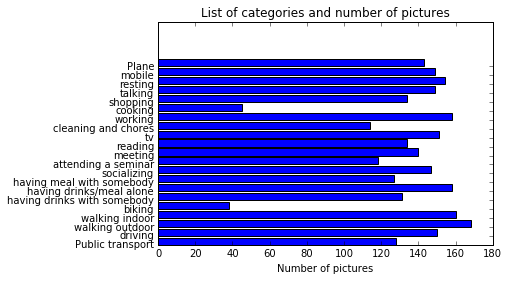

In [20]:
# Shows a histogram of the test set
paths = [[] for _ in range(NUM_LABELS)]
# each index index paths will contain a list of  pictures associated to a category
for i, path in enumerate(test_paths):
    paths[test_labels[i]].append(path)

y_pos = np.arange(NUM_LABELS)
num_examples = [len(examples) for examples in paths]
plt.barh(y_pos, num_examples,  alpha=1)
plt.yticks(y_pos, labels)
plt.xlabel('Number of pictures')
plt.title('List of categories and number of pictures')
plt.show()

## Training a forest with layers fc6 and probs
Here we are going to extract features batch by batch and train the forest meanwhile

In [21]:
# we are going to train the forest with these layers
layers = ('fc6', 'probs')
shape_features = extract_features_shape(activitiesnet, layers, BATCH_SIZE)
print "Shape of features of one batch", shape_features 
# just in case we modified the input size
activitiesnet, transformer = reshape_caffe_transformer(BATCH_SIZE, activitiesnet)
rf = maybe_train(activities_net['forest'], layers, force_train=FORCE_TRAIN, batches=USE_BATCHES)

Shape of features of one batch (1, 4117)
Generating the forest
Current index 0
Current index 500
Current index 1000
Current index 1500
Current index 2000
Current index 2500
Current index 3000
Current index 3500
Current index 4000
Current index 4500
Current index 5000
Current index 5500
Current index 6000
Current index 6500
Current index 7000
Current index 7500
Current index 8000
Current index 8500
Current index 9000
Current index 9500
Current index 10000
Current index 10500
Current index 11000
Current index 11500
Current index 12000
Current index 12500
Current index 13000
Current index 13500
Current index 14000
Current index 14500
Current index 15000
Current index 15500
Saving forest in /media/hermetico/2TB/frameworks/notebooks/TFG/dist/models/finetuning-alexnet/forest_fc6_probs.pck


Evaluate category accuracy

In [22]:
# FIRST of all we need to reshape the input of the net because we are going to test
# pictures one by one and not using a batch
activitiesnet, transformer = reshape_caffe_transformer(1, activitiesnet)

In [23]:
accuracies = eval_categories(activitiesnet, rf, paths, layers)

Class accuracy for a tree trained with a cnn layers ('fc6', 'probs')
Public transport: 83
driving: 100
walking outdoor: 85
walking indoor: 65
biking: 73
having drinks with somebody: 90
having drinks/meal alone: 83
having meal with somebody: 86
socializing: 85
attending a seminar: 92
meeting: 85
reading: 82
tv: 94
cleaning and chores: 60
working: 95
cooking: 35
shopping: 73
talking: 83
resting: 99
mobile: 87
Plane: 92


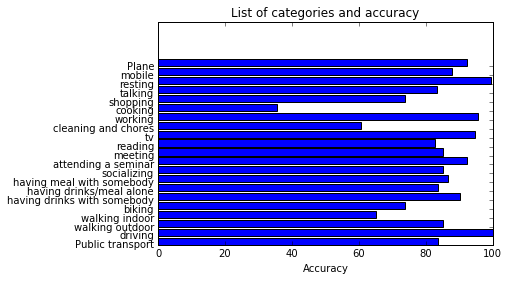

In [24]:
show_accuracies(accuracies, layers)

Global accuracy

In [25]:
glob_accuracy, top_labels = eval_global(activitiesnet, rf, test_paths, test_labels, layers)
print "Global accuracy for a trained with layers %s:  %2.f%% " %(layers, glob_accuracy)

Global accuracy for a trained with layers ('fc6', 'probs'):  85% 


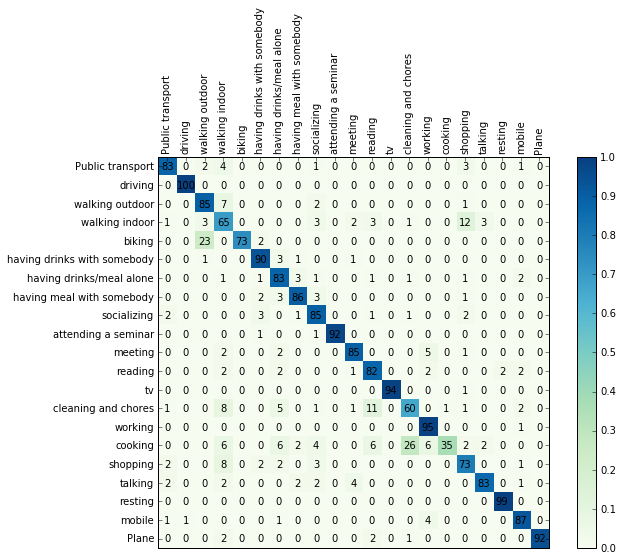

In [26]:
show_confusion_matrix(test_labels, top_labels, labels)

## Training a forest with layers fc7 and probs

In [27]:
# we are going to train the forest with these layers
layers = ('fc7', 'probs')
shape_features = extract_features_shape(activitiesnet, layers, BATCH_SIZE)
print "Shape of features of one batch", shape_features 
# just in case we ) modified the input size
activitiesnet, transformer = reshape_caffe_transformer(BATCH_SIZE, activitiesnet)
rf = maybe_train(activities_net['forest'], layers, force_train=FORCE_TRAIN, batches=USE_BATCHES)

Shape of features of one batch (1, 4117)
Generating the forest
Current index 0
Current index 500
Current index 1000
Current index 1500
Current index 2000
Current index 2500
Current index 3000
Current index 3500
Current index 4000
Current index 4500
Current index 5000
Current index 5500
Current index 6000
Current index 6500
Current index 7000
Current index 7500
Current index 8000
Current index 8500
Current index 9000
Current index 9500
Current index 10000
Current index 10500
Current index 11000
Current index 11500
Current index 12000
Current index 12500
Current index 13000
Current index 13500
Current index 14000
Current index 14500
Current index 15000
Current index 15500
Saving forest in /media/hermetico/2TB/frameworks/notebooks/TFG/dist/models/finetuning-alexnet/forest_fc7_probs.pck


In [28]:
activitiesnet, transformer = reshape_caffe_transformer(1, activitiesnet)

# class accuracy
accuracies = eval_categories(activitiesnet, rf, paths, layers)
# global accuracy
glob_accuracy, top_labels = eval_global(activitiesnet, rf, test_paths, test_labels, layers)

Class accuracy for a tree trained with a cnn layers ('fc7', 'probs')
Public transport: 83
driving: 98
walking outdoor: 84
walking indoor: 65
biking: 73
having drinks with somebody: 88
having drinks/meal alone: 82
having meal with somebody: 84
socializing: 82
attending a seminar: 90
meeting: 83
reading: 83
tv: 94
cleaning and chores: 55
working: 93
cooking: 37
shopping: 76
talking: 87
resting: 99
mobile: 90
Plane: 91


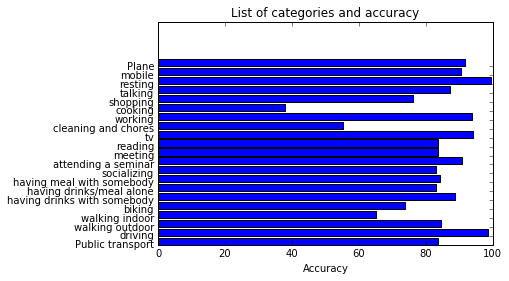

Global accuracy for a trained with layers ('fc7', 'probs'):  84% 


In [29]:
show_accuracies(accuracies, layers)
print "Global accuracy for a trained with layers %s:  %2.f%% " %(layers, glob_accuracy)

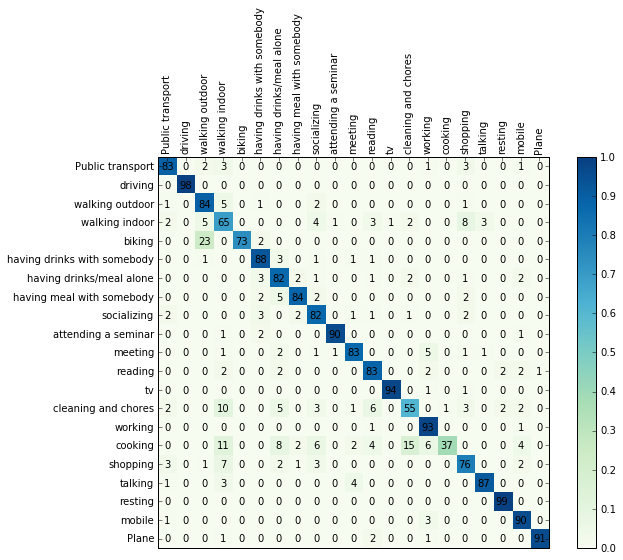

In [30]:
show_confusion_matrix(test_labels, top_labels, labels)

In [ ]:
#### Display random predictions

index = random.randint(0, len(test_paths))
print "with index", index
print "Top 1:"
print "Real label: %s, predicted label: %s" %(
    labels[test_labels[index]], 
    disp_pred(activitiesnet, rf,  labels,  test_paths[index], layers)
    )